In [1]:
%env OMP_NUM_THREADS=10

env: OMP_NUM_THREADS=10


In [2]:
import os
import random
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

from similarity_calculation import get_rdm, correlate_rdms

seed = 2022
np.random.seed(seed)
plt.rcParams['font.size'] = '14'

2023-02-21 14:42:21.476783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 14:42:21.791671: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 14:42:21.872407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 14:42:21.872452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes

def spike_matrix_step_ComplexImage_ntn(session, VIS_units_table, image_stim_table, bin=0.001, \
                                       period=0.1, blank=0.2, stim_before=0.05, stim_after=0.05, window=0.01):

    # using in this complexImage dataset, for VIS areas & nn/tex/noise stim

    stim_before = stim_before + window/2
    stim_after = stim_after - window/2
    time_bins = np.arange(0-stim_before, period+blank+stim_after+window+bin, bin)

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=image_stim_table.index,  
        bin_edges=time_bins,
        unit_ids=VIS_units_table['unit_id']
    ).values

    response_time = spike_counts.shape[1]-int(window/bin)
    response_matrix = np.zeros([spike_counts.shape[0], response_time, spike_counts.shape[2]])

    for t in np.arange(response_time):
        window_slider = np.arange(t, t+int(window/bin))
        spike_counts_2 = spike_counts_bins(spike_counts[:, window_slider, :], int(window/bin))
        response_matrix[:, t, :] = spike_counts_2[:, 0, :]

    return response_matrix

In [4]:
# # path to nwb location
# # local
# imagepath = r'E:\Jialab_newdata\variability_phase4\visual_stimuli\production'
# nwbpath = r"E:\Jialab_newdata\variability_phase4\nwb\production"
# mouse_id = '607187'
# pilot = 'production1'
# filename = mouse_id+'_'+pilot+'.spikes.nwb'

# path to nwb location
# remote
imagepath = '/data/decipher_variability/variability_phase4/visual_stimuli/production'
nwbpath = '/data/decipher_variability/variability_phase4/nwb/production'
pilot = 'production1'
# mouse_id = '610746'
# filename = mouse_id+'_'+pilot+'.spikes.nwb'
# session = EcephysSession.from_nwb_path(os.path.join(nwbpath,filename), api_kwargs= {
#                                                                                     "amplitude_cutoff_maximum": np.inf, 
#                                                                                     "presence_ratio_minimum": -np.inf, 
#                                                                                     "isi_violations_maximum": np.inf
#                                                                                     })         

mouseIDs = ['594534', '594584', '594585', '597503', '597504','597505','597506','597507',
            '599894', '602518', '607187', '607188', '610740', '610746', '612803']
selected_sessions = {}

for i, id in enumerate(mouseIDs):
    filename = id+'_'+pilot+'.spikes.nwb'
    session = EcephysSession.from_nwb_path(os.path.join(nwbpath,filename), api_kwargs= {
                                                                                        "amplitude_cutoff_maximum": np.inf, 
                                                                                        "presence_ratio_minimum": -np.inf, 
                                                                                        "isi_violations_maximum": np.inf
                                                                                        })
    selected_sessions[id] = session                                                                       

get ann model features layers

In [5]:
block_id = 'block1_1'
ann_model = 'AlexNet'   # alexnet, resnet, vgg11

stimulus_filename = f"/vault/jiangp/ANN_bj/internal_feature/stimulus.txt"
with open(stimulus_filename, "r") as f:
    stim_list = eval(f.readline())
stim_list = [os.path.split(filename)[1] for filename in stim_list]

img_meta = pd.read_csv(f'/data/decipher_variability/variability_phase4/visual_stimuli/production/images_{block_id}.csv')
stim_list_sorted = [fn.split('.')[0] for fn in img_meta['filename']]
print(len(stim_list_sorted))

# we need to find the corresponding from the random feature and the actual stimulus label, so we need this stim_perm_index
stim_perm_index = []
for stim in stim_list_sorted:
    stim_perm_index.append(stim_list.index(stim+".jpg"))

path = f"/vault/jiangp/ANN_bj/internal_feature/{ann_model}/{block_id}/"
file_paths = glob(f"{path}/*")
files = [os.path.split(filename)[1] for filename in file_paths]
stim_list_sorted = [fn.split('.')[0].split('_') for fn in files]
df = pd.DataFrame(stim_list_sorted, columns=['features', 'operator', 'layer'])
df = df.dropna()
df['layer'] = df['layer'].astype(int)
df = df.sort_values('layer')
df['file_name'] = df['features'] + '_' + df['operator'] + '_' + df['layer'].astype(str)

features_total = {}
for features_name in df['file_name']:
    arr = np.load(os.path.join(path, f"{features_name}.npy"))
    features_total[features_name] = arr[stim_perm_index]
    print(features_name, features_total[features_name].shape)
print(features_total.keys())

773
features_Conv2d_0 (773, 64, 55, 55)
features_ReLU_1 (773, 64, 55, 55)
features_MaxPool2d_2 (773, 64, 27, 27)
features_Conv2d_3 (773, 192, 27, 27)
features_ReLU_4 (773, 192, 27, 27)
features_MaxPool2d_5 (773, 192, 13, 13)
features_Conv2d_6 (773, 384, 13, 13)
features_ReLU_7 (773, 384, 13, 13)
features_Conv2d_8 (773, 256, 13, 13)
features_ReLU_9 (773, 256, 13, 13)
features_Conv2d_10 (773, 256, 13, 13)
features_ReLU_11 (773, 256, 13, 13)
features_MaxPool2d_12 (773, 256, 6, 6)
dict_keys(['features_Conv2d_0', 'features_ReLU_1', 'features_MaxPool2d_2', 'features_Conv2d_3', 'features_ReLU_4', 'features_MaxPool2d_5', 'features_Conv2d_6', 'features_ReLU_7', 'features_Conv2d_8', 'features_ReLU_9', 'features_Conv2d_10', 'features_ReLU_11', 'features_MaxPool2d_12'])


RDM similarity between feature_layers ofmand VIS_areas activity average during [50 : 150]ms, stim 

In [14]:
block_id = 'block1_1'
bin=0.001
period=0.1
blank=0.2
stim_before=0.05
stim_after=0.05
window=0.01
start_time = int((stim_before)/bin)
end_time = int((stim_before+period)/bin)
whole_time = int((stim_before+period+blank)/bin)
# sessions with neurons num > 120
mouses_id = ['594534', '594585', '597504', '597505', '610746', '612803', '607187']
areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
block_ids = ['block1_1', 'block1_2', 'block2_2']
stim_types = ['nn', 'tex', 'noise']
stim_period = np.arange(50, 150)  # ms
corr_area_layer_stim = np.zeros([len(mouses_id), len(areas), len(df['file_name'])])

stim_table_11_1 = pd.read_csv(imagepath+'/images_'+block_id+'.csv', index_col=0)
for m, mouse_id in enumerate(mouses_id):
    print(f'session_id:{mouse_id}')
    session = selected_sessions[mouse_id]
    stim_table_11_2 = session.get_stimulus_table(['block1_1_tiff'])
    stim_table_11_2['frame'] = stim_table_11_2['frame'].astype(int)
    stim_table_block11 = pd.merge(stim_table_11_1, stim_table_11_2, left_index=True, right_on='frame')
    VIS_units_table = pd.read_csv(f'/vault/jiangp/NDP_ComplexeImages/VIS_units_table_mouse_{mouse_id}.csv')
    response_matrix_block11 = np.load(f'/vault/jiangp/NDP_ComplexeImages/response_matrix_{block_id}_mouse_{mouse_id}.npy')

    # response_matrix_block11 = spike_matrix_step_ComplexImage_ntn(session, VIS_units_table, stim_table_block11)
    # print(f'response_matrix_block11: {response_matrix_block11.shape}')
    # np.save(f'/vault/jiangp/NDP_ComplexeImages/response_matrix_{block_id}_mouse_{mouse_id}', response_matrix_block11)

    # clear 10 repeats for each conditon
    n_repeats = 10
    n_images = stim_table_11_1.shape[0]
    _, n_bins, n_neurons = response_matrix_block11.shape

    response_matrix_images = np.zeros((n_images, n_bins, n_neurons))
    for i in range(n_images):
        response_matrix_images[i] = response_matrix_block11[stim_table_block11['frame']==i].mean(0)
    response_matrix_images = response_matrix_images[:, start_time:whole_time]
    print(f'response_matrix_images: {response_matrix_images.shape}')

    n_images, n_bins, n_neurons = response_matrix_images.shape
    response_matrix_stim = response_matrix_images[:, stim_period, :].mean(1)

    for a, area in enumerate(areas):
        # print(area)
        response_matrix_area = response_matrix_stim[:, VIS_units_table['area'] == area]
        rdm_area = get_rdm(response_matrix_area)

        for f, features_name in enumerate(df['file_name']):
            feature_matrix_layer = features_total[features_name]
            dim0, dim1, dim2, dim3 = feature_matrix_layer.shape
            feature_matrix_layer = feature_matrix_layer.reshape(dim0, dim1*dim2*dim3)
            rdm_layer = get_rdm(feature_matrix_layer)
            corr_area_layer_stim[m, a, f] = correlate_rdms(rdm_area, rdm_layer)

print(corr_area_layer_stim.shape)
   

session_id:594534
response_matrix_images: (773, 300, 870)
session_id:594585
response_matrix_images: (773, 300, 1122)
session_id:597504
response_matrix_images: (773, 300, 969)
session_id:597505
response_matrix_images: (773, 300, 981)
session_id:610746
response_matrix_images: (773, 300, 1037)
session_id:612803
response_matrix_images: (773, 300, 1000)
session_id:607187
response_matrix_images: (773, 300, 1091)
(7, 6, 13)


In [15]:
np.save(f'/vault/jiangp/ANN_bj/data/corr_area_layer_stim_{block_id}_{ann_model}', corr_area_layer_stim)

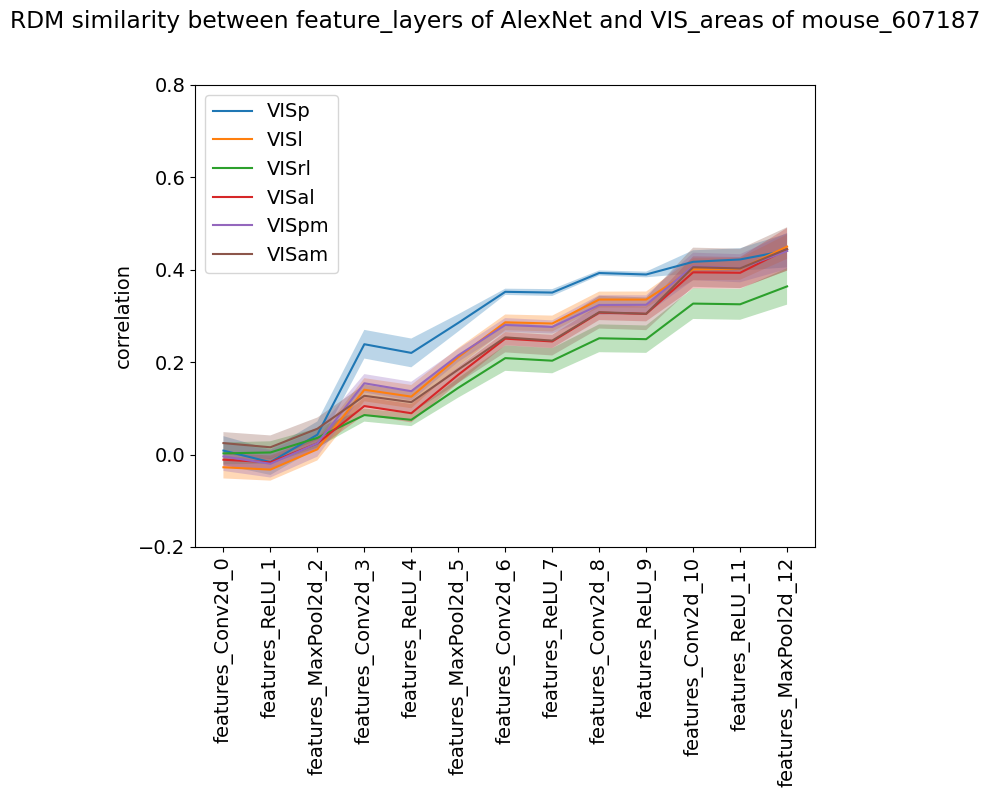

In [16]:
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
fig, ax = plt.subplots(figsize=(8, 6))
n_mouses, n_areas, n_features = corr_area_layer_stim.shape
for a, area in enumerate(areas):
    x = np.arange(n_features)
    mean = corr_area_layer_stim[:, a, :].mean(0)
    std = corr_area_layer_stim[:, a, :].std(0)
    se = std/np.sqrt(n_mouses)
    ax.plot(x, mean, c=color_list[a], label=area)
    ax.fill_between(x, mean+se, mean-se, facecolor=color_list[a], alpha=0.3)

ax.legend(loc='upper left')
# ax.set_title(f'RDM similarity between feature_layers of {ann_model} and VIS_areas of mouse_{mouse_id}')
ax.set_ylabel(f'correlation')
# ax.set_xlabel(f'time/ms')
ax.set_ylim((-0.2, 0.8))
# ax.set_xlim((-20, 320))
ax.set_xticks(range(n_features))
ax.set_xticklabels(df['file_name'], rotation=90)

# plt.tight_layout()
fig.suptitle(f'RDM similarity between feature_layers of {ann_model} and VIS_areas of mouse_{mouse_id}', x=0.5, y=1.005)
plt.show()

RDM similarity between feature_layers of and VIS_areas activity average during [50 : 150]ms, for stim_types = ['nn', 'tex', 'noise']

In [7]:
block_id = 'block1_1'
bin=0.001
period=0.1
blank=0.2
stim_before=0.05
stim_after=0.05
window=0.01
start_time = int((stim_before)/bin)
end_time = int((stim_before+period)/bin)
whole_time = int((stim_before+period+blank)/bin)
# sessions with neurons num > 120
mouses_id = ['594534', '594585', '597504', '597505', '610746', '612803', '607187']
areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
block_ids = ['block1_1', 'block1_2', 'block2_2']
stim_types = ['nn', 'tex', 'noise']
stim_period = np.arange(50, 150)  # ms
corr_area_layer_stim_types = np.zeros([len(mouses_id), len(stim_types), len(areas), len(df['file_name'])])

stim_table_11_1 = pd.read_csv(imagepath+'/images_'+block_id+'.csv', index_col=0)
for m, mouse_id in enumerate(mouses_id):
    print(f'session_id:{mouse_id}')
    session = selected_sessions[mouse_id]
    stim_table_11_2 = session.get_stimulus_table(['block1_1_tiff'])
    stim_table_11_2['frame'] = stim_table_11_2['frame'].astype(int)
    stim_table_block11 = pd.merge(stim_table_11_1, stim_table_11_2, left_index=True, right_on='frame')
    VIS_units_table = pd.read_csv(f'/vault/jiangp/NDP_ComplexeImages/VIS_units_table_mouse_{mouse_id}.csv')
    response_matrix_block11 = np.load(f'/vault/jiangp/NDP_ComplexeImages/response_matrix_{block_id}_mouse_{mouse_id}.npy')

    # response_matrix_block11 = spike_matrix_step_ComplexImage_ntn(session, VIS_units_table, stim_table_block11)
    # print(f'response_matrix_block11: {response_matrix_block11.shape}')
    # np.save(f'/vault/jiangp/NDP_ComplexeImages/response_matrix_{block_id}_mouse_{mouse_id}', response_matrix_block11)

    # clear 10 repeats for each conditon
    n_repeats = 10
    n_images = stim_table_11_1.shape[0]
    _, n_bins, n_neurons = response_matrix_block11.shape

    response_matrix_images = np.zeros((n_images, n_bins, n_neurons))
    for i in range(n_images):
        response_matrix_images[i] = response_matrix_block11[stim_table_block11['frame']==i].mean(0)
    response_matrix_images = response_matrix_images[:, start_time:whole_time]
    print(f'response_matrix_images: {response_matrix_images.shape}')

    n_images, n_bins, n_neurons = response_matrix_images.shape
    response_matrix_stim = response_matrix_images[:, stim_period, :].mean(1)

    for t, type in enumerate(stim_types):
        response_matrix_type = response_matrix_stim[stim_table_11_1['stim_type'] == type]

        for a, area in enumerate(areas):
            # print(area)
            response_matrix_area = response_matrix_type[:, VIS_units_table['area'] == area]
            rdm_area = get_rdm(response_matrix_area)

            for f, features_name in enumerate(df['file_name']):
                feature_matrix_layer = features_total[features_name]
                dim0, dim1, dim2, dim3 = feature_matrix_layer.shape
                feature_matrix_layer = feature_matrix_layer.reshape(dim0, dim1*dim2*dim3)
                rdm_layer = get_rdm(feature_matrix_layer)
                corr_area_layer_stim_types[m, t, a, f] = correlate_rdms(rdm_area, rdm_layer)

print(corr_area_layer_stim_types.shape)   

session_id:594534
response_matrix_images: (773, 300, 870)
session_id:594585
response_matrix_images: (773, 300, 1122)
session_id:597504
response_matrix_images: (773, 300, 969)
session_id:597505
response_matrix_images: (773, 300, 981)
session_id:610746
response_matrix_images: (773, 300, 1037)
session_id:612803
response_matrix_images: (773, 300, 1000)
session_id:607187
response_matrix_images: (773, 300, 1091)
(7, 3, 6, 13)


In [12]:
np.save(f'/vault/jiangp/ANN_bj/data/corr_area_layer_stim_types_{block_id}_{ann_model}', corr_area_layer_stim_types)

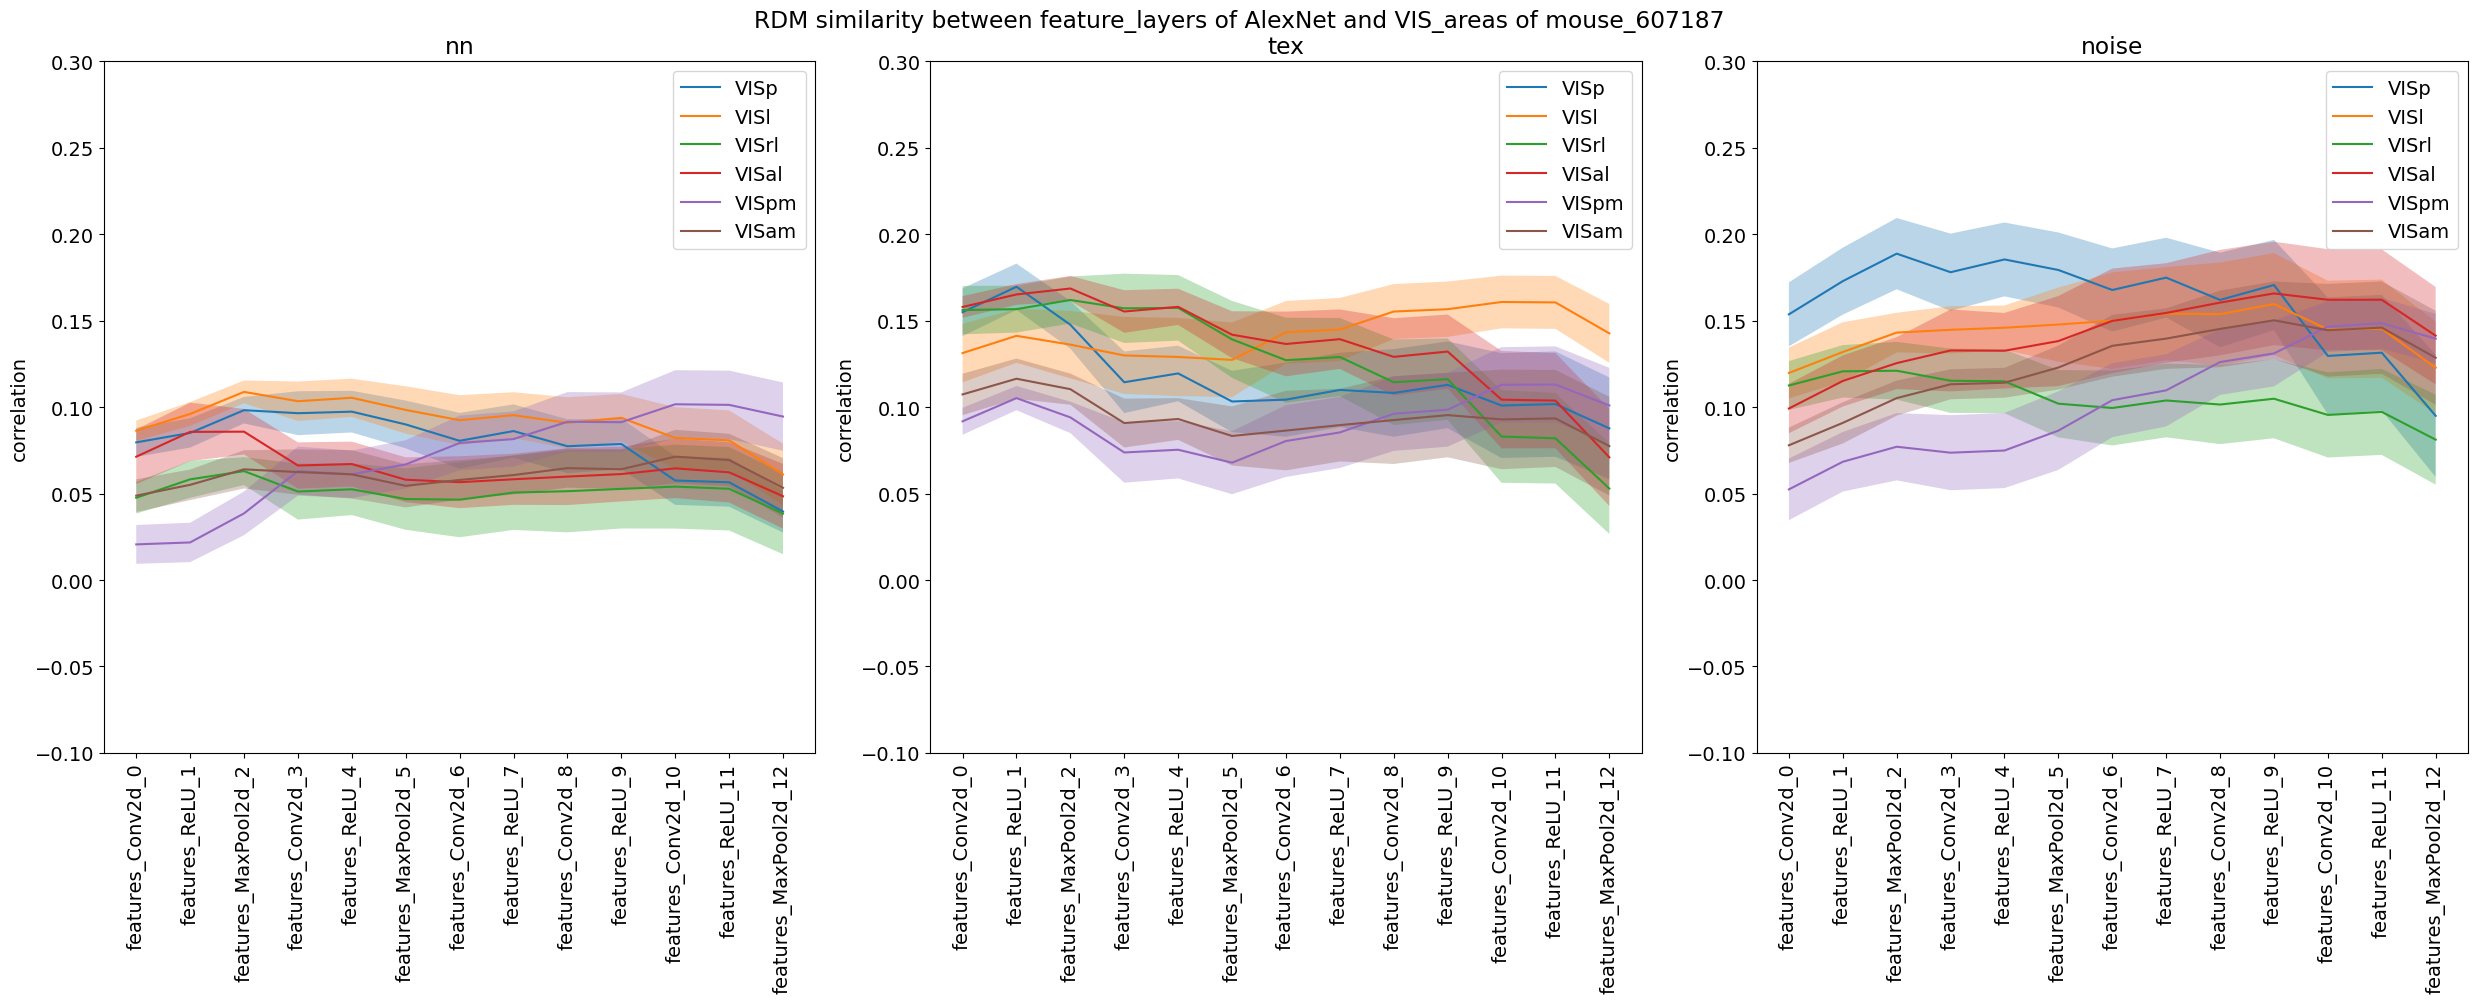

: 

In [17]:
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
fig, axes = plt.subplots(ncols=3, figsize=(25, 10))
n_mouses, n_types, n_areas, n_features = corr_area_layer_stim_types.shape

for t, type in enumerate(stim_types):
    for a, area in enumerate(areas):
        x = np.arange(n_features)
        mean = corr_area_layer_stim_types[:, t, a, :].mean(0)
        std = corr_area_layer_stim_types[:, t, a, :].std(0)
        se = std/np.sqrt(n_mouses)
        axes[t].plot(x, mean, c=color_list[a], label=area)
        axes[t].fill_between(x, mean+se, mean-se, facecolor=color_list[a], alpha=0.3)

    axes[t].legend()
    axes[t].set_title(f'{type}')
    axes[t].set_ylabel(f'correlation')
    # ax.set_xlabel(f'time/ms')
    axes[t].set_ylim((-0.1, 0.3))
    # ax.set_xlim((-20, 320))
    axes[t].set_xticks(range(n_features))
    axes[t].set_xticklabels(df['file_name'], rotation=90)

plt.tight_layout()
fig.suptitle(f'RDM similarity between feature_layers of {ann_model} and VIS_areas of mouse_{mouse_id}', x=0.5, y=1.005)
plt.show()